In [2]:
!pip install tensorflow_addons

In [3]:
import subprocess
import platform
import os
import itertools
import time
from IPython.display import display, HTML, Markdown, clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import (
    utils,
    models,
    layers,
    metrics,
    preprocessing,
    callbacks,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Reshape,
    Input,
    Dense,
    Dropout,
    Activation,
    Flatten,
    Conv2D,
    MaxPooling2D,
    average,
    Add,
    concatenate,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import tensorflow_addons as tfa

from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    make_scorer,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)

from scipy.signal import savgol_filter

def clear_screen():
    time.sleep(2)
    print("Clearing screen...")
    time.sleep(2)
    clear_output()

clear_screen()

In [4]:
import pandas as pd
import zipfile
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

#chest_xray_test_norm = files.upload()
#chest_xray_test_pneum = files.upload()

#chest_xray_train_norm = files.upload()
#chest_xray_test_pneum = files.upload()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
img_width, img_height = 64, 64
img_color_mode = "grayscale"  # can also be 'rgb'
classes = {0: "NORMAL", 1: "PNEUMONIA"}
n_classes = 2

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Lab6_ML/chest_xray/train",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode=img_color_mode,
    batch_size=32,
    image_size=(img_width, img_height),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5216 files belonging to 2 classes.


Found 624 files belonging to 2 classes.


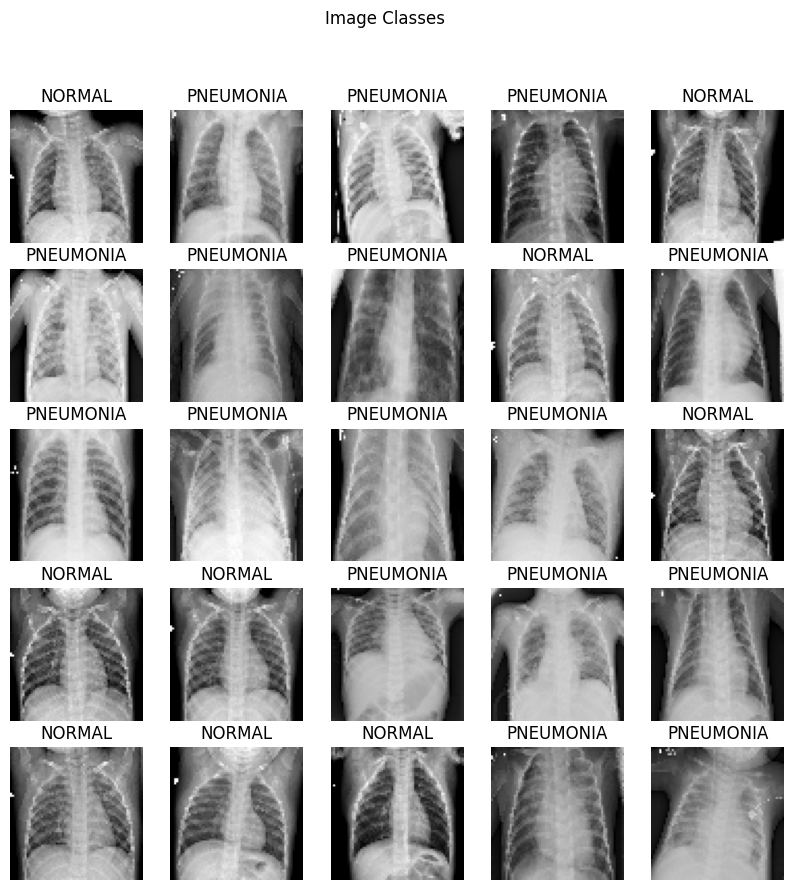

In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Lab6_ML/chest_xray/test",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode=img_color_mode,
    batch_size=32,
    image_size=(img_width, img_height),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Image Classes")
plt.show()

The provided code comprises functions for normalizing pixel values in images and converting TensorFlow datasets to numpy arrays.

The normalize function accepts an image and its label, normalizes the pixel values of the image to a range between 0 and 1, and returns the normalized image along with its label. Subsequently, the train_ds and test_ds datasets undergo normalization by mapping them to the normalize function.

Concluding the script, the process_ds_to_numpy function is employed to convert the train_ds and test_ds datasets into numpy arrays. The final line of the code determines the number of dimensions in the resulting x_train numpy array.

In [8]:
def normalize(image, label):
    """Normalize the pixel values of the image to be between 0 and 1."""
    return tf.cast(image, tf.float32) / 255.0, label


train_ds = train_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [9]:
def process_ds_to_numpy(ds) -> tuple:
    """Returns the x, y numpy arrays from the dataset."""
    x, y = [], []
    for image, label in ds:
        x.append(np.array(image, dtype=np.float32))
        y.append(np.array(label, dtype=np.int32))

    return np.concatenate(x, axis=0), np.concatenate(y, axis=0)

train_ds = train_ds.as_numpy_iterator()
test_ds = test_ds.as_numpy_iterator()

x_train, y_train = process_ds_to_numpy(train_ds)
x_test, y_test = process_ds_to_numpy(test_ds)

n_dimensions = x_train.shape[-1]

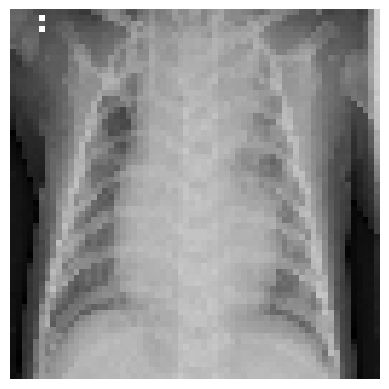

In [10]:
plt.imshow(x_train[0], cmap='gray')
plt.axis('off')
plt.show()

## MODELING

The ImageDataGenerator function is employed to dynamically apply diverse image transformations during model training, encompassing rotations, zooms, shifts, and flips. This generator is then configured to the training and test data through the fit method.

Introducing additional image transformations to the existing data serves to augment the size of our training dataset. Leveraging rotation, zoom, shift, and flip techniques exposes our models to varied image angles, enhancing their ability to make predictions based on both the original and augmented data. In the context of our citrus disease dataset, where diseases exhibit defining traits but manifest in numerous variations with distinct physical symptoms, generating images from existing ones facilitates the creation of diverse disease variations. This approach not only enriches the training data but also mitigates the risk of overfitting, ensuring our models are better equipped to generalize to various manifestations of the diseases.

In [11]:
datagen = preprocessing.image.ImageDataGenerator(
       rotation_range = 20,
       width_shift_range=0.1,
       height_shift_range=0.1,
       horizontal_flip = True,
       vertical_flip = False,
)
# Fits the data to the generator.
datagen.fit(x_train)

In [12]:
# One-hot encodes the inputs
# One-hot encoding is necessary for the model to output probabilities for each class during training and evaluation.
y_train_ohe = utils.to_categorical(y_train, n_classes)
y_test_ohe = utils.to_categorical(y_test, n_classes)

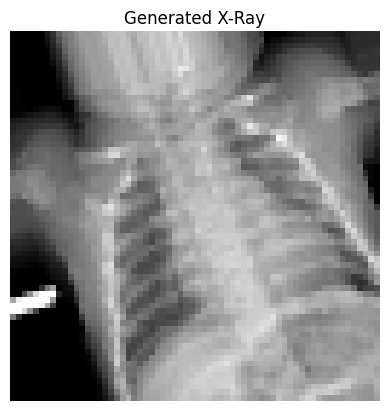

In [14]:
""" Reshapes the arrays to have a sample size of -1, and an image size of 64x64 with one channel, and
then expands the # dimensions of the arrays to include the channel dimension, resulting in a final shape
of (samples, image_rows, image_cols, image_channels)"""
import cv2

for tmp in datagen.flow(x_train, y_train_ohe, batch_size=1):
    plt.imshow(cv2.resize(tmp[0].squeeze(), (64, 64)), cmap='gray')
    plt.title("Generated X-Ray")
    plt.axis("off")
    break


## Helper Functions


In the following code segment, we establish a flow iterator by utilizing the previously defined image data generator object to produce augmented images in batches of size one from the training set. Subsequently, we employ matplotlib to visualize one of the augmented images.

To enhance visualization and gain insights into the augmented data, we specifically generate plots for 25 sample images from the training set. This allows us to observe the variations introduced through augmentation, providing a comprehensive view of the diverse transformations applied to the original images.

In [20]:
def plot_confusion_matrix(
    cm,
    target_names,
    title="Confusion matrix",
    cmap=None,
    normalize=True,
    class_results: dict = {},
):
    """
    Given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel("True label")
    if class_results:
        x_lab = "Predicted label\n\n"
        x_lab += f"accuracy={accuracy:0.4f}\nmisclass={misclass:0.4f}\n"
        for key, value in class_results.items():
            x_lab += f"{key}={value:0.4f}\n"
    else:
        x_lab = "Predicted label\n\n"
        x_lab += f"accuracy={accuracy:0.4f}\nmisclass={misclass:0.4f}\n"

    plt.xlabel(x_lab)
    plt.show()



In the code below, a helper function named compare_mlp_cnn is introduced. This function takes the following inputs:

cnn and mlp: the trained convolutional neural network and multilayer perceptron models, respectively.
X_test and y_test: the testing data and corresponding labels.
labels: an optional list of class labels, defaulting to 'auto'.
The primary purpose of this function is to assess and compare the performance of the CNN and MLP models on the test data. It achieves this by making predictions for class labels and subsequently computing accuracy scores and confusion matrices. The results are then visualized using a heatmap, leveraging the seaborn library. This visualization aids in providing an intuitive representation of the comparative performance between the two models on the test data.

In [16]:
def compare_mlp_cnn(model_1, model_2, X_test, y_test, title_1: str, title_2: str, labels='auto'):
    plt.figure(figsize=(15, 5))
    if model_1 is not None:
        yhat_model_1 = np.argmax(model_1.predict(X_test), axis=1)
        acc_model_1 = metrics.accuracy_score(y_test, yhat_model_1)
        plt.subplot(1, 2, 1)
        cm = metrics.confusion_matrix(y_test, yhat_model_1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels)
        plt.title(f"{title_1}: {acc_model_1:.3f}")

    if model_2 is not None:
        yhat_model_2 = np.argmax(model_2.predict(X_test), axis=1)
        acc_model_2 = metrics.accuracy_score(y_test, yhat_model_2)
        plt.subplot(1, 2, 2)
        cm = metrics.confusion_matrix(y_test,yhat_model_2)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels)
        plt.title(f"{title_2}: {acc_model_2:.3f}")


In [17]:
# Evaluates the performance of a model during training and identifying overfitting or underfitting.
def plot_history(history):
    # plot history of the model:
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")

In [18]:
"""The summarize_net helper function is designed to provide a comprehensive summary of a neural network
model's performance. This function takes the following inputs:

- net: the neural network model.
- x_test: the test set features.
- y_test: the test set labels.
- An optional string parameter for the title of the plot.

The function utilizes the predict method of the model to generate predictions for the test set. It then
computes the accuracy score by comparing these predicted labels with the actual labels. Additionally,
the function calculates the confusion matrix, normalizes it, and presents it as aheatmap using the Seaborn
library. The title of the plot is constructed to include the accuracy score formatted to four decimal places,
along with any optional title text provided to the function. This visual representation aids in effectively
summarizing the model's performance on the given test set."""

def summarize_net(net, x_test, y_test, title_text=""):
    label = ["NORMAL","PNEUMONIA"]
    plt.figure(figsize=(15, 5))
    yhat = np.argmax(net.predict(x_test), axis=1)
    acc = metrics.accuracy_score(y_test, yhat)
    cm = metrics.confusion_matrix(y_test, yhat)
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt=".2%", xticklabels=label, yticklabels=label)
    plt.title(title_text + "{:.4f}".format(acc))